<a href="https://colab.research.google.com/github/ankesh86/ASPNETMVCStoreApp/blob/main/GANS/DiffusionModel_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

os.getcwd()

'/content'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/pytorch-diffusion-master

/content/drive/MyDrive/pytorch-diffusion-master


In [4]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 51.8 MB/s eta 0:00:00


In [5]:
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from data import DiffSet
from model import DiffusionModel
from torch.utils.data import DataLoader


In [6]:
diffusion_steps = 100
dataset_choice = 'MNIST'
max_epoch = 10
batch_size = 128

load_model = False
load_version_num = 1

In [7]:
pass_version = None
last_checkpoint = None

if load_model:
  pass_version = load_version_num
  last_checkpoint = glob.glob(
      f"./lightning_logs/{dataset_choice}/version_{load_version_num}/checkpoints/*.ckpt"
  )[-1]

In [24]:
train_dataset = DiffSet(True, dataset_choice)
val_dataset = DiffSet(True, dataset_choice)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

In [25]:
if load_model:
  model = DiffusionModel.load_from_checkpoint(last_checkpoint, in_size = train_dataset.size*train_dataset.size,
                                              t_range = diffusion_steps, img_depth = train_dataset.depth)
else:
  model = DiffusionModel(train_dataset.size*train_dataset.size, diffusion_steps, train_dataset.depth)

In [26]:
# Load Trainer model
tb_logger = pl.loggers.TensorBoardLogger(
    "lightning_logs/",
    name=dataset_choice,
    version=pass_version,
)

trainer = pl.Trainer(
    max_epochs=max_epoch,
    log_every_n_steps=10,
    accelerator="gpu",
    devices=1,
    logger=tb_logger,
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [27]:
# Train model with checkpoint
trainer.fit(model, train_loader, val_loader, ckpt_path=last_checkpoint)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name  | Type       | Params | Mode 
----------------------------------------------
0  | inc   | DoubleConv | 37.7 K | train
1  | down1 | Down       | 295 K  | train
2  | down2 | Down       | 1.2 M  | train
3  | down3 | Down       | 2.4 M  | train
4  | up1   | Up         | 6.2 M  | train
5  | up2   | Up         | 1.5 M  | train
6  | up3   | Up         | 406 K  | train
7  | outc  | OutConv    | 65     | train
8  | sa1   | SAWrapper  | 395 K  | train
9  | sa2   | SAWrapper  | 395 K  | train
10 | sa3   | SAWrapper  | 99.6 K | train
----------------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.676    Total estimated model params size (MB)
141       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [33]:
sample_batch_size = 9

gen_samples = []
x = torch.randn((sample_batch_size, train_dataset.depth, train_dataset.size, train_dataset.size))
sample_steps = torch.arange(model.t_range, 0, -1)
for t in sample_steps:
    x = model.denoise_sample(x, t)
    if t % 50 == 0:
        gen_samples.append(x)

In [34]:
len(gen_samples)

2

In [35]:
gen_samples[0].shape

torch.Size([9, 1, 32, 32])

In [36]:
gen_samples = torch.stack(gen_samples, dim = 0).moveaxis(2, 4).squeeze(-1)
gen_samples = (gen_samples.clamp(-1, 1) + 1) / 2

In [37]:
gen_samples.shape

torch.Size([2, 9, 32, 32])

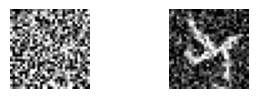

In [38]:
fig = plt.figure(figsize = (12, 6))

for i in range(gen_samples.shape[0]):
    plt.subplot(5, 6, i + 1)
    plt.imshow((gen_samples[i, 4 , :, :] *255).type(torch.uint8), cmap = 'gray')
    plt.axis('off')